<a href="https://colab.research.google.com/github/gloriankosi/notebooks/blob/main/chest_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
! mkdir ~/.kaggle
! cp drive/MyDrive//kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

train_dir = os.path.abspath(os.getcwd()) + "/chest_xray/train/"
test_dir = os.path.abspath(os.getcwd()) + "/chest_xray/test/"

print(train_dir)
print(tf.__version__)

/content/chest_xray/train/
2.6.0


In [4]:
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="training", seed=543, validation_split=0.2, labels='inferred')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, subset="validation", seed=543, validation_split=0.2, labels='inferred')
print('-----')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir)
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels='inferred')
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,labels='inferred')
print(train_ds.class_names)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
-----
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


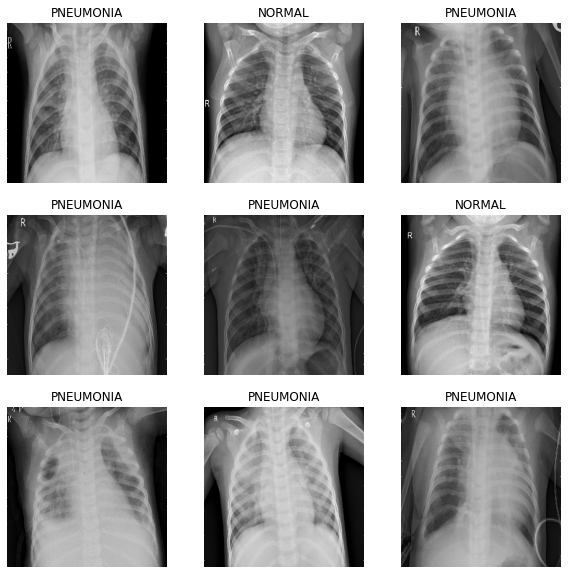

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

## A look at dimensions

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
print(image_batch[0])

(32, 256, 256, 3)
(32,)
tf.Tensor(
[[[150.21484  150.21484  150.21484 ]
  [147.50781  147.50781  147.50781 ]
  [151.46094  151.46094  151.46094 ]
  ...
  [ 28.902344  28.902344  28.902344]
  [ 27.46875   27.46875   27.46875 ]
  [ 25.136719  25.136719  25.136719]]

 [[148.22266  148.22266  148.22266 ]
  [139.08984  139.08984  139.08984 ]
  [136.91016  136.91016  136.91016 ]
  ...
  [ 30.625     30.625     30.625   ]
  [ 29.292969  29.292969  29.292969]
  [ 26.78125   26.78125   26.78125 ]]

 [[140.34766  140.34766  140.34766 ]
  [129.83203  129.83203  129.83203 ]
  [110.40625  110.40625  110.40625 ]
  ...
  [ 32.375     32.375     32.375   ]
  [ 31.175781  31.175781  31.175781]
  [ 29.        29.        29.      ]]

 ...

 [[ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  [ 11.        11.        11.      ]
  ...
  [ 11.21875   11.21875   11.21875 ]
  [ 12.        12.        12.      ]
  [ 12.        12.        12.      ]]

 [[ 11.        11.        11.      ]
  

According to the documentation (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory#returns), 3 channels (last dimension of image_batch tensor) corresponds to color channels RGB. Needs standardization to go from RGB to grayscale. We can introduce rescaling through `layers.experimental.preprocessing.Rescaling`.

## Model #1

In [7]:
num_classes = 2
model_1 = Sequential(
    [
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)), # rescaling layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu') ,
    layers.MaxPooling2D(),
    layers.Dense(128) ,
    layers.Flatten(),
    layers.Dense(num_classes) ,
    ]
)

In [8]:
model_1.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model_1.build(input_shape=image_batch.shape)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 64, 64, 128)       8320      
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0

In [10]:
checkpoint_path = "/content/drive/MyDrive/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Training Model #1 (5 epochs)

In [11]:
epochs=5
model_1_history = model_1.fit(
  train_ds, 
  validation_data=val_ds,
  epochs=epochs , 
  callbacks=[cp_callback]
)

Epoch 1/5
131/131 [==============================] - 442s 3s/step - loss: 0.7374 - accuracy: 0.8656 - val_loss: 0.1396 - val_accuracy: 0.9492

Epoch 00001: saving model to /content/drive/MyDrive/training_1/cp.ckpt
Epoch 2/5
131/131 [==============================] - 441s 3s/step - loss: 0.0946 - accuracy: 0.9669 - val_loss: 0.1084 - val_accuracy: 0.9588

Epoch 00002: saving model to /content/drive/MyDrive/training_1/cp.ckpt
Epoch 3/5
131/131 [==============================] - 442s 3s/step - loss: 0.0669 - accuracy: 0.9753 - val_loss: 0.1096 - val_accuracy: 0.9636

Epoch 00003: saving model to /content/drive/MyDrive/training_1/cp.ckpt
Epoch 4/5
131/131 [==============================] - 441s 3s/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.0814 - val_accuracy: 0.9741

Epoch 00004: saving model to /content/drive/MyDrive/training_1/cp.ckpt
Epoch 5/5
131/131 [==============================] - 442s 3s/step - loss: 0.0240 - accuracy: 0.9911 - val_loss: 0.0862 - val_accuracy: 0.9732

E

In [12]:
model_1.load_weights(checkpoint_path)
loss, acc = model_1.evaluate(val_ds)

33/33 [==============================] - 33s 967ms/step - loss: 0.0862 - accuracy: 0.9732


In [13]:
model_1_history.history

{'accuracy': [0.8655643463134766,
  0.9669302701950073,
  0.9753175377845764,
  0.9849029183387756,
  0.991133451461792],
 'loss': [0.7373746633529663,
  0.09459032863378525,
  0.0669102594256401,
  0.04462283104658127,
  0.0239721592515707],
 'val_accuracy': [0.9491850137710571,
  0.9587727785110474,
  0.9635666608810425,
  0.9741131067276001,
  0.9731543660163879],
 'val_loss': [0.13963696360588074,
  0.10843009501695633,
  0.10962694138288498,
  0.08142893761396408,
  0.08624721318483353]}

### Test data with Model #1 (5 epochs)

In [50]:
for images,labels in test_ds.take(2):
  for i in range(9):
    img_array = tf.expand_dims(images[i], 0)
    predictions = model_1.predict(img_array)
    score = tf.nn.softmax(predictions)
    print("Predicted:", test_ds.class_names[np.argmax(score)], 100 * np.max(score))
    print("Actual:" , train_ds.class_names[labels[i]])
    print()

Predicted: PNEUMONIA 99.99971389770508
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99997615814209
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99985694885254
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99949932098389
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.97474551200867
Actual: PNEUMONIA

Predicted: PNEUMONIA 67.47508645057678
Actual: NORMAL

Predicted: PNEUMONIA 99.98282194137573
Actual: PNEUMONIA

Predicted: NORMAL 67.22244024276733
Actual: NORMAL

Predicted: PNEUMONIA 90.87014198303223
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.9862551689148
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.99997615814209
Actual: PNEUMONIA

Predicted: PNEUMONIA 99.94118213653564
Actual: PNEUMONIA

Predicted: PNEUMONIA 87.03495860099792
Actual: PNEUMONIA

Predicted: PNEUMONIA 79.66657876968384
Actual: NORMAL

Predicted: PNEUMONIA 99.99998807907104
Actual: PNEUMONIA

Predicted: PNEUMONIA 98.77523183822632
Actual: PNEUMONIA

Predicted: NORMAL 64.25657272338867
Actual: PNEUMONIA

Predicted: NORMAL 99.299603700

In [16]:
# TODO: show images + more metrics

## Model #2